<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/main/Resunet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Definition of ResUNet architecture"""
# Taken from https://github.com/nikhilroxtomar/Deep-Residual-Unet/blob/master/Deep%20Residual%20UNet.ipynb

from tensorflow import keras

def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def get_model(input_shape):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((input_shape[0], input_shape[1], input_shape[2]))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

from keras import backend as K

# Focal Tversky_loss
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

def get_loss_function(loss_function_name):
    if loss_function_name == "focal_tversky_loss":
        loss_function = focal_tversky_loss
    elif loss_function_name == "dice_coef_loss":
        loss_function = dice_coef_loss
    elif loss_function_name == "dice_coef_binary_loss":
        loss_function = dice_coef_binary_loss
    elif loss_function_name == "focal_loss":
        loss_function = focal_loss
    elif loss_function_name == "sparse_categorical_crossentropy":
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    else:
        loss_function = loss_function_name # for keras implemented losses like "categorical_crossentropy"

    return loss_function

2023-12-02 23:15:22.340253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 23:15:22.340279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 23:15:22.340305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 23:15:22.345853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/is/.local/lib/python3.10/site-packages/scipy

In [2]:
INPUT_FEATURES = ['elevation', 'wind_speed', 'wind_dir', 'tmin', 'tmax',
                  'landcover', 'precip', 'pdsi','solar', 'PrevFireMask']

In [3]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
# import model_satunet
import glob
import os
import sys


# Get loss function
loss_function = get_loss_function('dice_coef_loss')

# Define model architecture
model = get_model([64,64,10])

# Callbacks
#!pip install wandb
#import wandb
#from wandb.keras import WandbCallback

callbacks = list()

# Optional: WandB callback config and init
config = {
    "dataset_id": "NDFP_data",
    "img_size": [64,64],
    "model_architecture": 'resunet',
    "num_layers_satunet": 4,
    "unfreeze_all_layers": False,
    "parent_model_name": None,
    "optimizer": 'adam',
    "learning_rate": 0.0001,
    "loss_function": 'dice_coef_loss',
    "epochs": 100,
    "batch_size": 100,
    "custom_objects": [
        "dice_coef",
        "focal_tversky_loss"
        ],
    "input_features": INPUT_FEATURES
    }
#wandb.init(project='fire-model', config=config)
#run_name = wandb.run.name
#callbacks.append(WandbCallback())

# Define learning rate schedule callback
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=15, decay_rate=0.96, staircase=True
    )

#Define checkpoints callback
#checkpoint_path = os.path.join('./output', 'model', 'fire_model_{}.h5'.format(run_name))
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#    checkpoint_path, save_weights_only=True, save_best_only=True
#    )
#callbacks.append(checkpoint_cb)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2023-12-02 23:15:24.092722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 23:15:24.096417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 23:15:24.096531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#from google.colab import drive
#drive.mount('drive')

In [5]:
man_length = 21550

MinMax = {'landcover':(10.0, 100.0),
              'tmax': (-41.95404185202824, 35.28747487720835),
              'tmin': (-42.4077221254351, 34.710974191122716),
              'wind_speed': (0.0002993076576944125, 14.27423496286687),
              'elevation': (-77.85292, 4379.4683),
              'wind_direction': (-179.99999083334689, 179.99999810000588),
              'solar_radiation': (-24.598765964771623, 964662.1183104622),
              'air_pressure': (99064.73425290409, 105551.80433948596),
              'precipitation': (-9.494998975299606e-05, 0.012117456275976952)}

In [6]:
import csv
import gzip
import numpy as np

In [7]:
def normalize(arr, min_value, max_value):
  arr = np.array(arr)
  return (arr - min_value) / (max_value - min_value)

In [8]:
def _float_feature(value):
    """Returns a float_list from a list of float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [9]:
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
tfrecord_file = 'data2.tfrecords'

In [10]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tensor, [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    #tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tensor, [64, 64])
    

    return combined_features, label

In [11]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [12]:
count_records(tfrecord_file)

21550

In [13]:
dataset = tf.data.TFRecordDataset(tfrecord_file).cache()

dataset = dataset.map(_parse_function)


In [14]:
from tqdm import tqdm 
def list_record_features(tfrecords_path):
    # Dict of extracted feature information
    features = {}
    # Iterate records
    #dataset = tf.data.Dataset.list_files(tfrecords_path)
    for rec in tqdm(tf.data.TFRecordDataset([str(tfrecords_path)])):
        # Get record bytes
        example_bytes = rec.numpy()
        # Parse example protobuf message

        keys_to_features = {
            'feature1': tf.io.VarLenFeature(tf.float32),
            'feature2': tf.io.VarLenFeature(tf.float32),
            'feature3': tf.io.VarLenFeature(tf.float32),
            'feature4': tf.io.VarLenFeature(tf.float32),
            'feature5': tf.io.VarLenFeature(tf.float32),
            'feature6': tf.io.VarLenFeature(tf.float32),
            'feature7': tf.io.VarLenFeature(tf.float32),
            'feature8': tf.io.VarLenFeature(tf.float32),
            'feature9': tf.io.VarLenFeature(tf.float32),
            'feature10': tf.io.VarLenFeature(tf.float32),
            'label': tf.io.VarLenFeature(tf.float32)
        }
    
        # Load one example
        parsed_features = tf.io.parse_single_example(example_bytes, keys_to_features)
        
        feature_list = []
        #try:
        for i in range(1, 11):
            shp = tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))
            if shp != [4096]:
                feature = tf.zeros([64, 64])
                print(f"feature {i}, shape : {shp}")
            else:
                feature = tf.reshape(tf.sparse.to_dense(parsed_features[f'feature{i}']), [64, 64])
            feature_list.append(feature)
        #except:
        #    pass
    
        combined_features = tf.stack(feature_list, axis=-1)
        label = tf.zeros([64, 64], tf.float32)
        #try:
        shp = tf.shape(tf.sparse.to_dense(parsed_features[f'label']))
        if shp != [4096]:
            print(f"feature {i}, shape : {shp}")
        else:
            label = tf.reshape(tf.sparse.to_dense(parsed_features['label']), [64, 64])
        #except:
        #    pass

    return combined_features, label

#list_record_features('data.tfrecords')

In [15]:
# for inputs, labels in dataset:
#     print(inputs.shape)

In [16]:
cnt = 0
for inputs, labels in tqdm(dataset):
    cnt += 1
print(cnt)

21550it [00:04, 5261.41it/s]

21550


In [17]:
dataset = dataset.shuffle(buffer_size=man_length)

In [18]:
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

In [19]:
cnt = 0
for inputs, labels in tqdm(train_dataset):
    cnt += 1
print(cnt)

17240it [00:04, 4125.72it/s]

17240


In [20]:
cnt = 0
for inputs, labels in tqdm(test_dataset):
    cnt += 1
print(cnt)

2155it [00:01, 1201.97it/s]

2155


In [21]:
cnt = 0
for inputs, labels in tqdm(eval_dataset):
    cnt += 1
print(cnt)

2155it [00:01, 1243.36it/s]

2155


In [22]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Trainset analysis

inputs.shape: (32, 64, 64, 10)
labels.shape: (32, 64, 64)
len(TITLES): 11


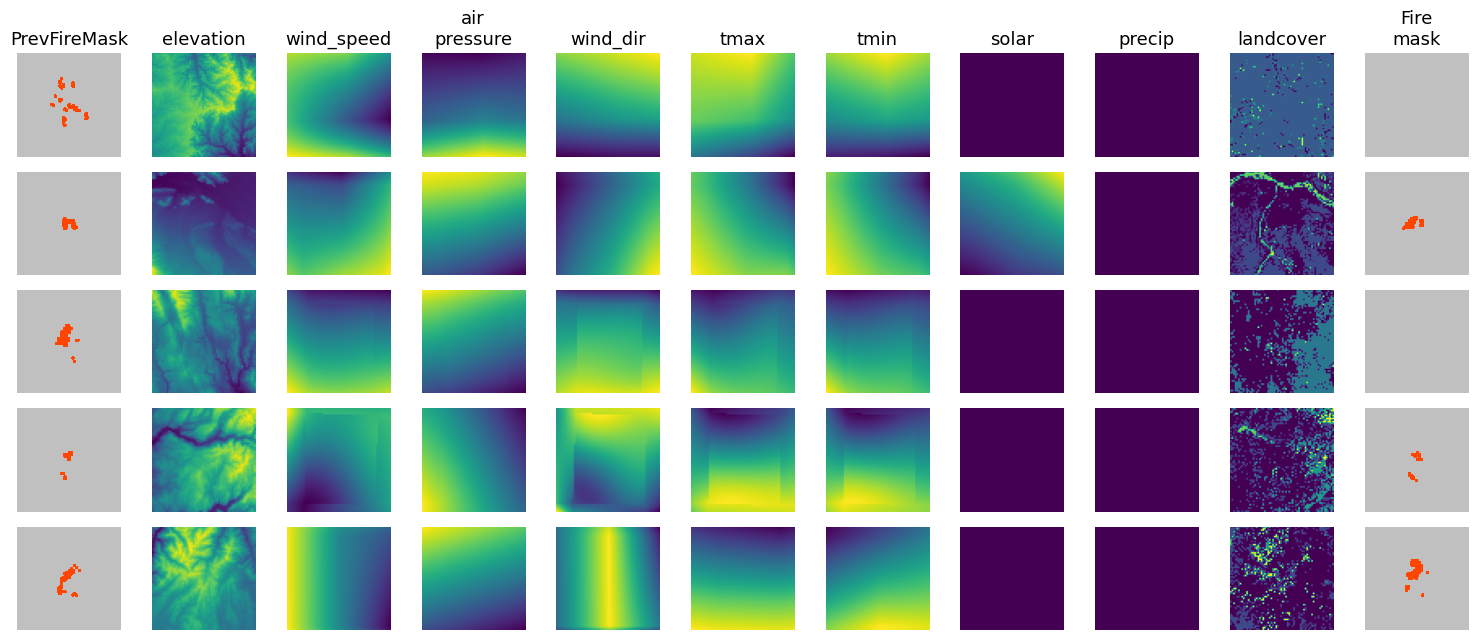

In [23]:
inputs, labels = next(iter(train_dataset))
print(f"inputs.shape: {inputs.shape}")
print(f"labels.shape: {labels.shape}")

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']
print(f"len(TITLES): {len(TITLES)}")


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# len(eval_dataset.take(1))

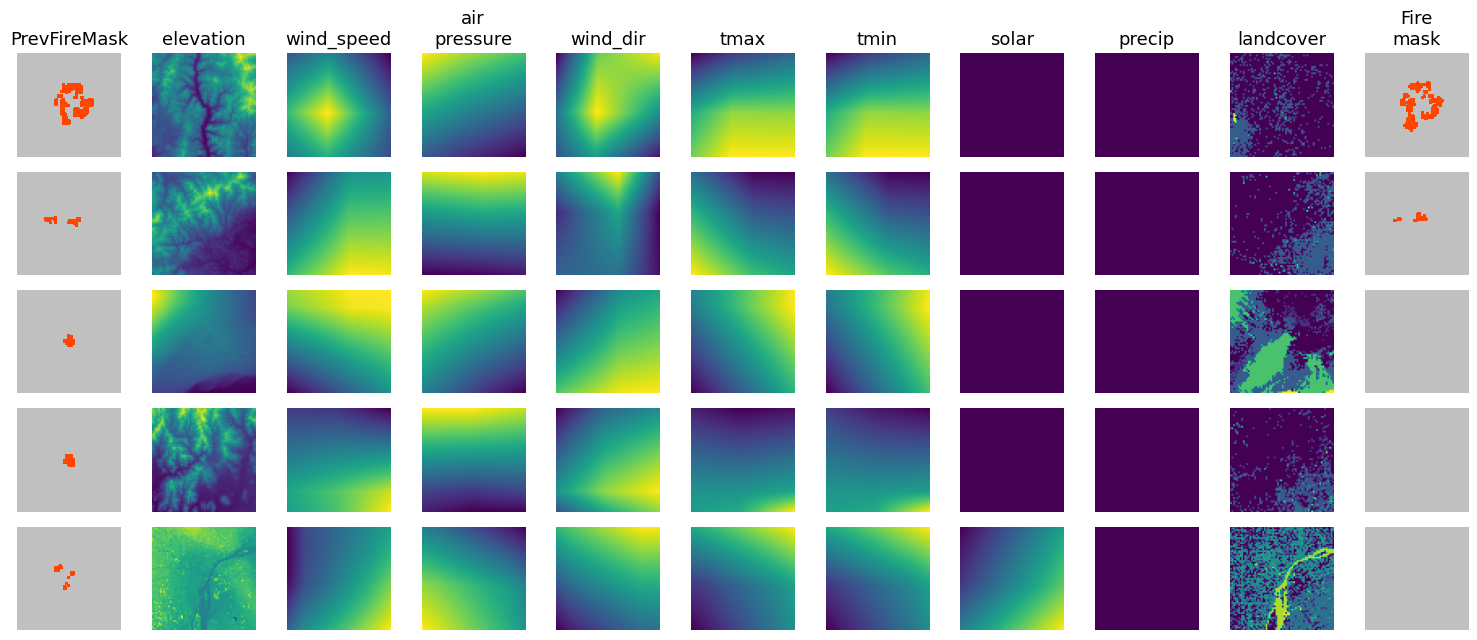

In [25]:
eval_dataset = eval_dataset.shuffle(1000)
inputs, labels = next(iter(eval_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

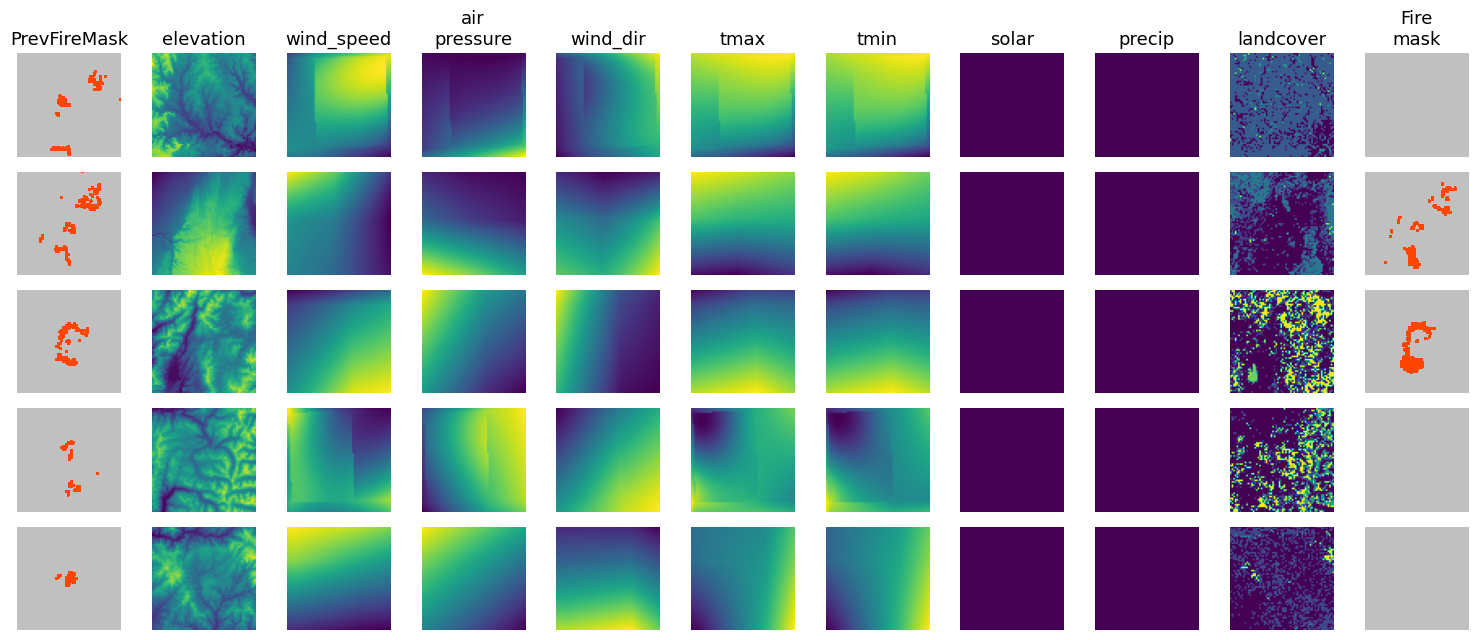

In [26]:
inputs, labels = next(iter(test_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 10)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           1456      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 16)           0         ['batch_normalization[0][0

# Training

In [28]:
# Compile and train model
model.compile(
    optimizer=optimizer,
    loss=loss_function, metrics=[dice_coef,
                                 #tf.keras.metrics.AUC(curve="PR"),
                                 #tf.keras.metrics.Precision(),
                                 #tf.keras.metrics.Recall()
                                ]
    )

#model.fit(train_dataset, epochs=5)
history = model.fit(
    train_dataset,
    #validation_data=eval_dataset,
    epochs=50,
    #callbacks=callbacks
)

Epoch 1/50


2023-12-02 23:15:51.736326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-02 23:15:51.823392: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-02 23:15:52.636568: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f67be76bd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 23:15:52.636588: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-02 23:15:52.639919: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-02 23:15:52.689895: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 [==============================] - 27s 27ms/step - loss: 0.7910 - dice_coef: 0.2089
Epoch 2/50
539/539 [==============================] - 15s 25ms/step - loss: 0.7459 - dice_coef: 0.2540
Epoch 3/50
539/539 [==============================] - 15s 25ms/step - loss: 0.7305 - dice_coef: 0.2695
Epoch 4/50
539/539 [==============================] - 15s 25ms/step - loss: 0.7277 - dice_coef: 0.2723
Epoch 5/50
539/539 [==============================] - 15s 25ms/step - loss: 0.7225 - dice_coef: 0.2775
Epoch 6/50
539/539 [==============================] - 15s 25ms/step - loss: 0.7241 - dice_coef: 0.2759
Epoch 7/50
539/539 [==============================] - 15s 26ms/step - loss: 0.7257 - dice_coef: 0.2743
Epoch 8/50
539/539 [==============================] - 15s 26ms/step - loss: 0.7251 - dice_coef: 0.2750
Epoch 9/50
539/539 [==============================] - 15s 26ms/step - loss: 0.7272 - dice_coef: 0.2728
Epoch 10/50
539/539 [==============================] - 15s 26ms/step - loss: 0.7214 

# Evaluation

In [29]:
# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Get all samples from TFRecords in arrays
first_it = True
cnt = 0
for x, y in test_dataset:
    cnt += 1
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
print(f"test inputs num batches = {cnt}")
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)
print(f"test_data_targets.shape {test_data_targets.shape}")
print(f"test_data_inputs.shape {test_data_inputs.shape}")

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, 0].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_true_flat = y_true.flatten()

test inputs num batches = 68
test_data_targets.shape (2155, 64, 64)
test_data_inputs.shape (2155, 64, 64, 10)


In [30]:
# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)

Accuracy: 0.983939
score_a (array([0.99662281, 0.15456474]), array([0.9871933 , 0.41173288]), array([0.99188565, 0.22475597]), array([8776969,   49911]))
precision 0.9839393987456496
Recall: 0.983939
F1 score: 0.983939
[[8664565  112404]
 [  29361   20550]]


In [31]:
# Predict
y_pred=list()
for sample in tqdm(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    # print("\niter\n")
    # #print(f"sample_exp.shape: {sample_exp.shape}")
    # #im = sample_exp[0, :, :, -1]
    # #print(f"im.shape: {im.shape}")
    # plt.imshow(sample_exp[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    pred = model.predict(sample_exp, verbose = 0)
    
    # #print(f"pred.shape: {pred.shape}")
    # plt.imshow(pred[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2155/2155 [01:12<00:00, 29.83it/s]


Accuracy: 0.989918
score_a (array([0.99641458, 0.24338874]), array([0.99343486, 0.37138106]), array([0.99492249, 0.29406119]), array([8776969,   49911]))
precision 0.9899175019939095
Recall: 0.989918
F1 score: 0.989918
[[8719347   57622]
 [  31375   18536]]


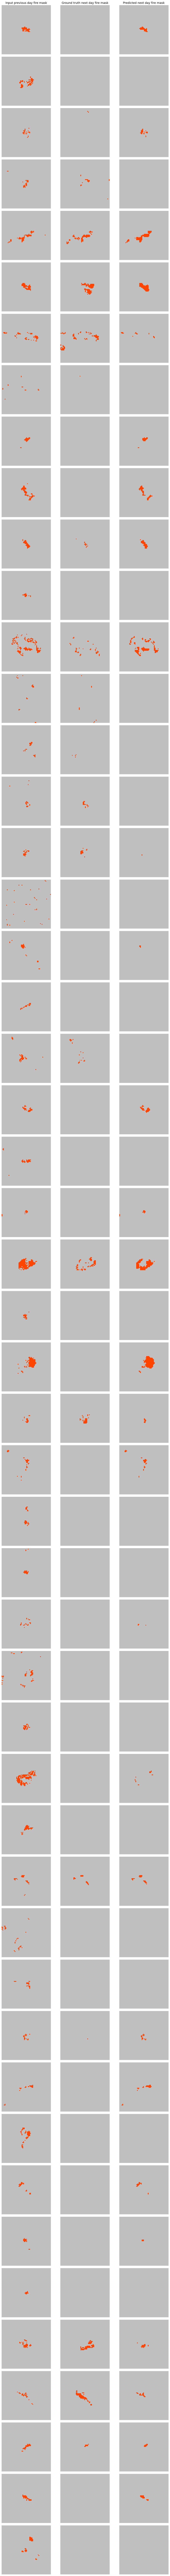

In [32]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [33]:
def get_model_encoder(input_shape):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((input_shape[0], input_shape[1], input_shape[2]))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Classifier head
    features = tf.keras.layers.Flatten()(b1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(features)
    model = keras.models.Model(inputs, outputs)
    return model


discriminator = get_model_encoder([64,64,11])
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 11)]         0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 64, 64, 16)           1600      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_28 (Ba  (None, 64, 64, 16)           64        ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 64, 64, 16)           0         ['batch_normalization_28

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
def build_gan(generator, discriminator, image_shape, conditional_image_shape):
    condition_input_placeholder = Input(shape = (conditional_image_shape), name = 'ConditionInput')
    generated_image = generator([condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator(tf.concat([generated_image, condition_input_placeholder], axis=-1))
    gan = Model([condition_input_placeholder], validity)
    return gan

In [35]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
CONDITIONAL_IMAGE_CHANNELS = 10
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
CONDITIONAL_IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CONDITIONAL_IMAGE_CHANNELS)

generator = model
gan = build_gan(generator, discriminator, (64, 64, 1), CONDITIONAL_IMAGE_SHAPE)

In [36]:
gan_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
gan.compile(loss = 'binary_crossentropy', optimizer = gan_optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = gan_optimizer)

In [37]:
from tqdm import tqdm_notebook
EPOCHS = 8

for epoch in range(EPOCHS):
    progress_bar = tqdm_notebook(desc = "Epoch: {0}".format(epoch), total = int(21550*0.8))
    generator_loss_history, discriminator_loss_history, dice_loss_history = [], [], []
    for features, next_day_fire in train_dataset:
        features = tf.convert_to_tensor(features)
        next_day_fire = tf.convert_to_tensor(next_day_fire)
        
        cur_batch_size = features.shape[0] 
        
        # Fake Images
        generated_next_day_fire = generator.predict(features, verbose=None)
        next_day_fire = tf.expand_dims(next_day_fire, axis=-1)
        
        # Batch Dataset
        x = tf.concat((next_day_fire, generated_next_day_fire), 0)
        #y = np.array([1] * cur_batch_size + [0] * cur_batch_size)
        y = tf.concat((tf.ones(cur_batch_size), tf.zeros(cur_batch_size)), 0)
        discriminator_conditions = tf.concat((features, features), 0)
        
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch(tf.concat([x, discriminator_conditions], axis=-1), y)
        discriminator_loss_history.append(discriminator_loss)
        
        # noise = tf.random.uniform((cur_batch_size, LATENT_DIMENSION), 0, 1)
        noise = tf.random.normal((cur_batch_size, LATENT_DIMENSION))
        
        # Training the Generator
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([features], tf.ones(cur_batch_size))
        generator_loss_history.append(generator_loss)
        discriminator.trainable = True

        # Training the image segmentation
        # noise = tf.random.uniform((cur_batch_size, LATENT_DIMENSION), 0, 1)
        #noise = np.zeros((cur_batch_size, LATENT_DIMENSION))
        #dice_loss = generator.train_on_batch([noise, features], next_day_fire)
        #dice_loss_history.append(dice_loss)
        
        progress_bar.update(cur_batch_size)
        progress_bar.set_description(f"Epoch {epoch} generator_loss:{generator_loss:.5f} discriminator_loss: {discriminator_loss:.5f}")
    print(f"Epoch {epoch} generator_loss:{generator_loss:.5f} discriminator_loss: {discriminator_loss:.5f}")

/tmp/ipykernel_2990402/4076380403.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(desc = "Epoch: {0}".format(epoch), total = int(21550*0.8))


Epoch: 0:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 0 generator_loss:0.69734 discriminator_loss: 0.65060


Epoch: 1:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 1 generator_loss:0.76761 discriminator_loss: 0.76023


Epoch: 2:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 2 generator_loss:0.81003 discriminator_loss: 0.70357


Epoch: 3:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 3 generator_loss:0.74758 discriminator_loss: 0.76573


Epoch: 4:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 4 generator_loss:0.68877 discriminator_loss: 0.70393


Epoch: 5:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 5 generator_loss:0.73924 discriminator_loss: 0.68593


Epoch: 6:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 6 generator_loss:0.64746 discriminator_loss: 0.70110


Epoch: 7:   0%|          | 0/17240 [00:00<?, ?it/s]

Epoch 7 generator_loss:0.74351 discriminator_loss: 0.65141


# Unused

In [38]:
# @tf.function
# def train_step(features, labels, iter):
#     with tf.device('/device:GPU:0'):
#         labels = tf.expand_dims(labels, axis=-1)
#         #print(f"features.shape: {features.shape} labels.shape: {labels.shape}")
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as train_tape:
#             generated_fire = generator(features, training=True)
            
#             real_input = tf.concat((features, labels), axis=-1)
#             gen_input = tf.concat((features, generated_fire), axis=-1)
#             #print(f"real_input.shape: {real_input.shape}")
#             real_output = discriminator(real_input, training=True)
#             gen_output = discriminator(gen_input, training=True)
#             discriminator_loss = cross_entropy(real_output, tf.ones_like(real_output)) +\
#                 cross_entropy(gen_output, tf.zeros_like(gen_output))
#             generator_loss = cross_entropy(gen_output, tf.ones_like(gen_output))
#             #train_loss = loss_function(generated_fire, labels)
    
#         #t_losses.append(train_loss.numpy())
#         #t_losses.append(0)
#         #g_losses.append(generator_loss.numpy())
#         #d_losses.append(discriminator_loss.numpy())
    
#         #train_gradients_of_generator = train_tape.gradient(train_loss, generator.trainable_variables)
#         gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
#         gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
#         #print(f"train_gradients_of_generator: {train_gradients_of_generator}")
#         #print(f"gradients_of_generator: {gradients_of_generator}")
#         #print(f"gradients_of_discriminator: {gradients_of_discriminator}")
        
#         generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#         if iter % print_interval == 0:
#            # tf.print(f"ep {ep} iter {iter} d_loss: {d_losses[-1]} g_loss: {g_losses[-1]} t_loss: {t_losses[-1]}")
#             tf.print(f"ep {ep} iter {iter} d_loss: {discriminator_loss} g_loss: {generator_loss} t_loss: {0}")

In [39]:
# tf.debugging.set_log_device_placement(True)


# generator = model
# generator_loss = loss_function
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# g_losses = []
# d_losses = []
# t_losses = []
# iter = 0
# iter_max = 300
# print_interval = 10


# for ep in range(1):
#     for features, labels in tqdm(train_dataset, total=int(21550*0.8)):
#         features = tf.convert_to_tensor(features)
#         labels = tf.convert_to_tensor(labels)
#         train_step(features, labels, iter)
        
#         # labels = tf.expand_dims(labels, axis=-1)
#         # #print(f"features.shape: {features.shape} labels.shape: {labels.shape}")
#         # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as train_tape:
#         #     generated_fire = generator(features, training=True)
            
#         #     real_input = tf.concat((features, labels), axis=-1)
#         #     gen_input = tf.concat((features, generated_fire), axis=-1)
#         #     #print(f"real_input.shape: {real_input.shape}")
#         #     real_output = discriminator(real_input, training=True)
#         #     gen_output = discriminator(gen_input, training=True)
#         #     discriminator_loss = cross_entropy(real_output, tf.ones_like(real_output)) +\
#         #         cross_entropy(gen_output, tf.zeros_like(gen_output))
#         #     generator_loss = cross_entropy(gen_output, tf.ones_like(gen_output))
#         #     #train_loss = loss_function(generated_fire, labels)
    
#         #     #t_losses.append(train_loss.numpy())
#         #     t_losses.append(0)
#         #     g_losses.append(generator_loss.numpy())
#         #     d_losses.append(discriminator_loss.numpy())
    
#         #     #train_gradients_of_generator = train_tape.gradient(train_loss, generator.trainable_variables)
#         #     gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
#         #     gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
#         #     #print(f"train_gradients_of_generator: {train_gradients_of_generator}")
#         #     #print(f"gradients_of_generator: {gradients_of_generator}")
#         #     #print(f"gradients_of_discriminator: {gradients_of_discriminator}")
            
#         #     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#         #     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#         # if iter % print_interval == 0:
#         #    print(f"ep {ep} iter {iter} d_loss: {d_losses[-1]} g_loss: {g_losses[-1]} t_loss: {t_losses[-1]}")
#         iter += 1

#         if iter >= iter_max:
#             break
    
    
#     # print(f"real_output.shape: {real_output.shape}")
    
#     # gen_loss = generator_loss(generated_fire, labels)
        
# #         
# #         real_input = features, labels
# #         real_output = discriminator(images, training=True)
# #         fake_output = discriminator(generated_images, training=True)

# #   
# #   disc_loss = discriminator_loss(real_output, fake_output)

# # gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
# # gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

# # generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
# # discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Evaluation

In [40]:
# Predict
y_pred=list()
for sample in tqdm_notebook(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    # print("\niter\n")
    # #print(f"sample_exp.shape: {sample_exp.shape}")
    # #im = sample_exp[0, :, :, -1]
    # #print(f"im.shape: {im.shape}")
    # plt.imshow(sample_exp[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    pred = model.predict(sample_exp, verbose = 0)
    
    # #print(f"pred.shape: {pred.shape}")
    # plt.imshow(pred[0, :, :, -1], cmap=CMAP, norm=NORM)
    # plt.show()
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

/tmp/ipykernel_2990402/3446776043.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(test_data_inputs):


  0%|          | 0/2155 [00:00<?, ?it/s]

Accuracy: 0.992288
score_a (array([0.99492588, 0.18357959]), array([0.99733074, 0.10554788]), array([0.99612686, 0.13403386]), array([8776969,   49911]))
precision 0.9922882150884571
Recall: 0.992288
F1 score: 0.992288
[[8753541   23428]
 [  44643    5268]]


In [41]:
# 0
np.where(y_true_flat < 1.)[0].shape

(8776969,)

In [42]:
# 1
np.where(y_true_flat > 0.)[0].shape

(49911,)

In [43]:
y_true.shape

(2155, 64, 64)

In [44]:
tf.unique(persistence_mask_flat)

Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(8826880,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

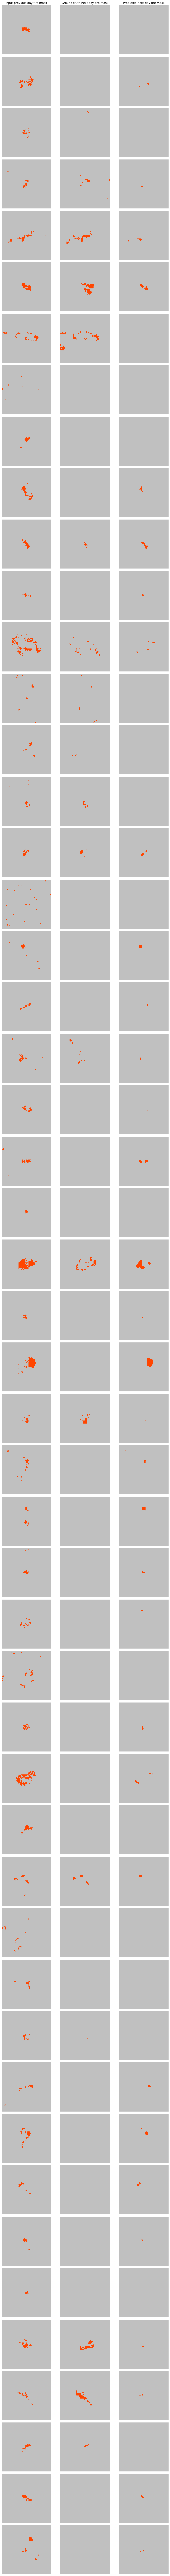

In [45]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

# Final metrics

In [46]:
import re
import numpy as np

# Input data
data = """
Accuracy: 0.992184
score_a (array([0.99446809, 0.17169326]), array([0.9976868 , 0.07952591]), array([0.99607484, 0.10870239]), array([8773979,   52901]))
precision 0.9921841012906032
Recall: 0.992184
F1 score: 0.992184
[[8753683   20296]
 [  48694    4207]]

Accuracy: 0.991898
score_a (array([0.99471585, 0.08539884]), array([0.99714994, 0.04783552]), array([0.99593141, 0.06132199]), array([8778046,   48834]))
precision 0.9918979299593967
Recall: 0.991898
F1 score: 0.991898
[[8753028   25018]
 [  46498    2336]]

Accuracy: 0.992288
score_a (array([0.99492588, 0.18357959]), array([0.99733074, 0.10554788]), array([0.99612686, 0.13403386]), array([8776969,   49911]))
precision 0.9922882150884571
Recall: 0.992288
F1 score: 0.992288
[[8753541   23428]
 [  44643    5268]]
"""

# Extracting values using regular expressions
accuracy_values = [float(match.group(1)) for match in re.finditer(r"Accuracy: (\d+\.\d+)", data)]
precision_values = [float(match.group(1)) for match in re.finditer(r"precision (\d+\.\d+)", data)]
recall_values = [float(match.group(1)) for match in re.finditer(r"Recall: (\d+\.\d+)", data)]
f1_score_values = [float(match.group(1)) for match in re.finditer(r"F1 score: (\d+\.\d+)", data)]

# Calculating mean and standard deviation
mean_accuracy = np.mean(accuracy_values)
std_accuracy = np.std(accuracy_values)

mean_precision = np.mean(precision_values)
std_precision = np.std(precision_values)

mean_recall = np.mean(recall_values)
std_recall = np.std(recall_values)

mean_f1_score = np.mean(f1_score_values)
std_f1_score = np.std(f1_score_values)

# Displaying results
format_string = "{:.5f}+={:.5f}"
print(f"Accuracy: {format_string.format(mean_accuracy, std_accuracy)}")
print(f"Precison: {format_string.format(mean_precision, std_precision)}")
print(f"Recall: {format_string.format(mean_recall, std_recall)}")
print(f"F1 Score: {format_string.format(mean_f1_score, std_f1_score)}")

Accuracy: 0.99212+=0.00016
Precison: 0.99212+=0.00017
Recall: 0.99212+=0.00016
F1 Score: 0.99212+=0.00016
